# Results - MIMIC

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
if sys.version_info[0] == 3:
    from importlib import reload
import warnings
warnings.filterwarnings('ignore')

os.chdir('/share/pi/boussard/eroosli_work/benchmarking')
import models.evaluation.learningcurves as lc
import models.evaluation.calibration as cb
import models.evaluation.performance as pm

In [2]:
json_strat = json.load(open('models/outputs/mimic/predictions/confvals/2020-06-03_9-38.stratified_ihm_results.json'))
json_nonstrat = json.load(open('models/outputs/mimic/predictions/confvals/2020-06-03_9-50.nonstratified_ihm_results.json'))

# Performance analysis

### Part 1: Discrimination

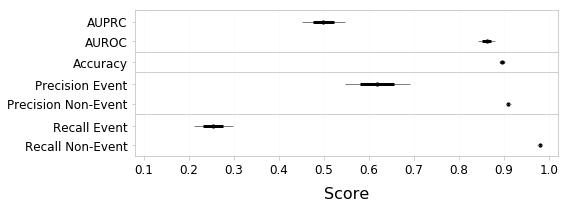

In [3]:
output_json = json_strat
pm.plot_metrics_overall(output_json, 'mimic')

> - Recall of the event is very low: linked to strong class imbalance 
> - Accurancy, Precision & Recall of Non-Event is very stable across bootstrapping

### Part 2: Calibration

- Number of Hosmer-Lemeshow groups = 10
- Nonparametric LOWESS smoothing considers 50% of points for each estimation
- Red line: decision threshold used for binary prediction (at predicted risk = 50%)

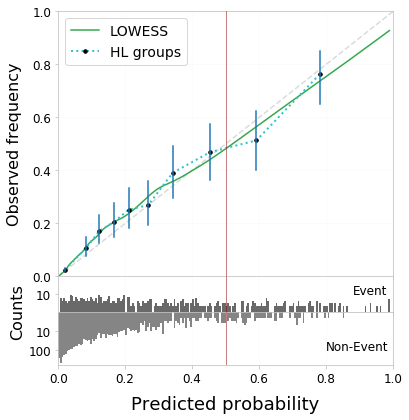

In [4]:
path_results = 'models/outputs/mimic/predictions/results/TEST.2020-04-22_14-11.k_clstms.none.csv'
results = cb.results_csv(path_results)
reload(cb)
cb.calibration_overall(results, "overall", data='mimic')

> Results show that calibration overall is rather good: slight underestimation of risk at lower risk scores and overestimation of higher risk scores

# Fairness Analysis

## Concept #1: Anti-classification

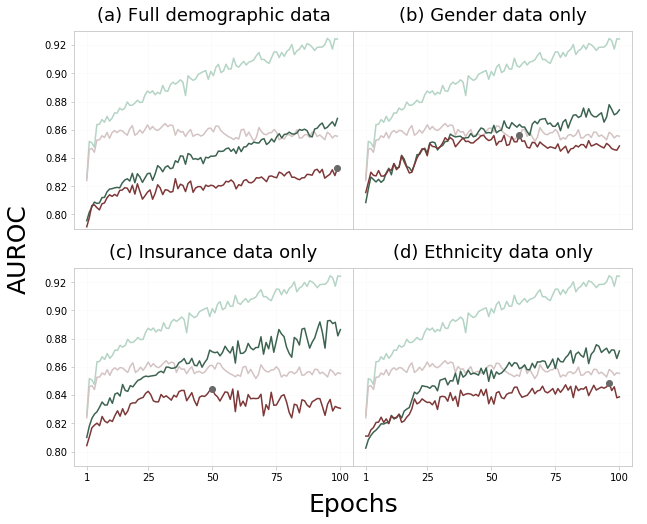

In [5]:
path_keras_logs = 'models/outputs/mimic/keras_logs'
path_clstm_basic = os.path.join(path_keras_logs, '2020-04-08_15-25.k_clstms.none.csv')
epochs_cbasic = lc.epoch_csv(path_clstm_basic)
path_clstm_aug = os.path.join(path_keras_logs, '2020-03-31_10-31.k_clstms.gender.insurance.ethnicity.csv')
epochs_aug = lc.epoch_csv(path_clstm_aug)
path_clstm_gen = os.path.join(path_keras_logs, '2020-04-01_18-42.k_clstms.gender.csv')
epochs_gen = lc.epoch_csv(path_clstm_gen)
path_clstm_ins = os.path.join(path_keras_logs, '2020-04-01_23-37.k_clstms.insurance.csv')
epochs_ins = lc.epoch_csv(path_clstm_ins)
path_clstm_eth = os.path.join(path_keras_logs, '2020-04-02_16-59.k_clstms.ethnicity.csv')
epochs_eth = lc.epoch_csv(path_clstm_eth)
dfs = [epochs_aug, epochs_gen, epochs_ins, epochs_eth]
lc.plot_learningcurves_2by2(dfs, epochs_cbasic, data='mimic')

> Interestingly, all four models performed considerably worse in terms of AUROC than the baseline model, which respected the anti-classification requirement. Figure \ref{fig:epochs} shows the training (darkgreen) and validation (darkred) learning curves of the four models. The faded curves corresponding to the baseline model allow for a direct comparison. Model (a) with all three demographic variables has not converged yet after the maximum number of training epochs and performs the worst. The model with data on \texttt{Gender} experiences the lowest performance degradation. These results suggest that using additional demographic information in the neural network to predict IHM not only does \textit{not} provide any useful insights, but in fact has \textit{deleterious} effects. The models not only take longer to converge, but also are incapable of reaching the same level of performance. Hence, the demographic data seems to mislead the model in its predictions purely based on physiological data. 

## Concept #2: Classification parity

- 10'000 bootstrapping on test set (resampling with replacement, while keeping proportions of outcomes fixed for every demographic group)
- 95% confidence intervals (grey line), SD in bold black, dot indicates median value

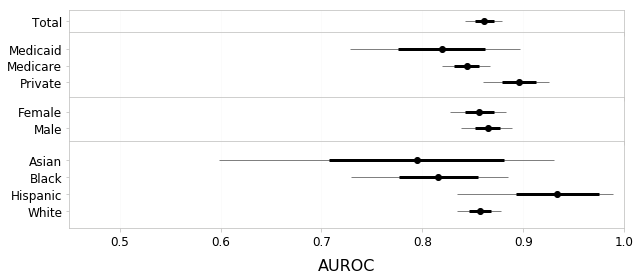

In [6]:
output_json = json_strat
reload(pm)
pm.plot_metric_grouped(output_json, "AUC of ROC", 'mimic')

> Overview
- large variations for small groups: Medicaid, Hispanic, Black, Asian
- good results: private insurance, males

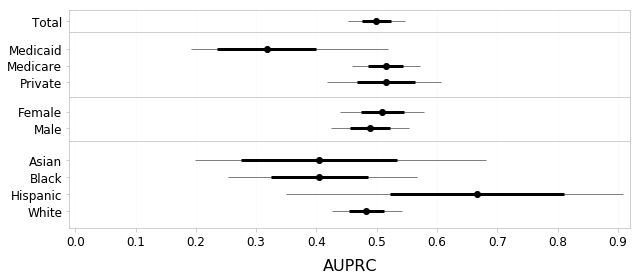

In [7]:
pm.plot_metric_grouped(output_json, "AUC of PRC", 'mimic')

> Overview:
- Random model: AUC of PRC = average IHM in data
- Insurance: Medicaid bad
- Gender: F slightly advantaged
- Ethnicity: Hispanic surprisingly good, Black and Asian both worse than average

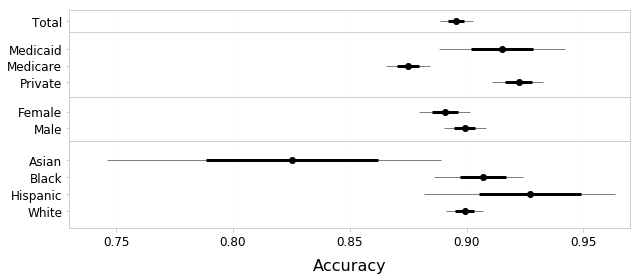

In [8]:
reload(pm)
pm.plot_metric_grouped(output_json, "Accuracy", 'mimic')

> Overview:
- Insurance: Private again best, Medicare worst
- Gender: Males again best
- Ethnicity: Asian considerably lower than the rest, large variation for small groups

> **Summary of last three plots:**
- Insurance: Private consistently best, Medicare and Medicaid considerably worse depending on measure
- Gender: Males better for accuracy and AUC-ROC, but not AUC-PRC (might be linked to lower overall IHM)
- Ethnicity: Asian consistently worst performance, Hispanic consistenly best performance

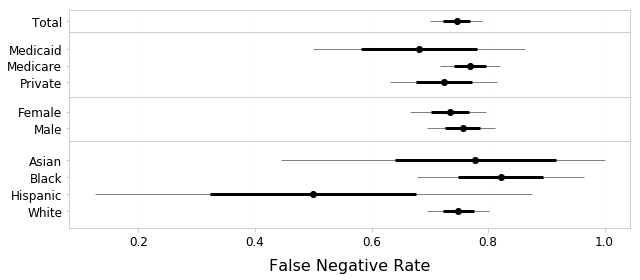

In [9]:
pm.plot_metric_grouped(output_json, "False Negative Rate", 'mimic')

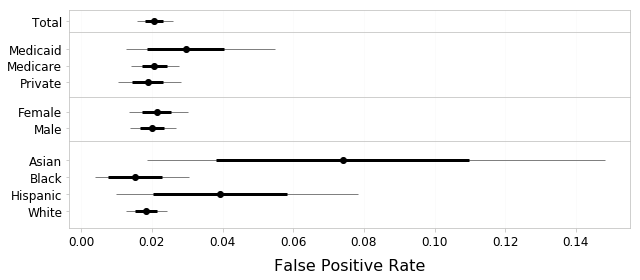

In [10]:
pm.plot_metric_grouped(output_json, "False Positive Rate", 'mimic')

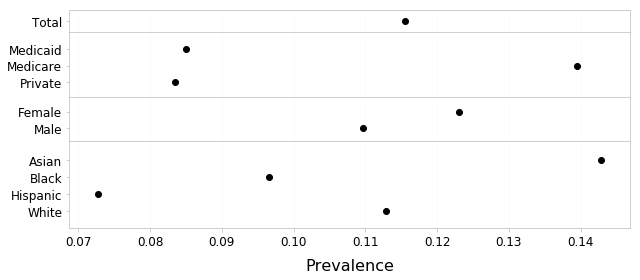

In [11]:
pm.plot_metric_grouped(output_json, "Prevalence", 'mimic')

> - large variation for ethnic groups (except white): due to small sample size
> - gender differences not significant
> - insurance type has interesting results, especially for AUC-ROC and Accuracy
> - other plot idea: different metrics for insurance in same plot
> - false negative rate very high
> - **Q**: plots for which metrics make sense (to e.g. keep for thesis)? 

## Concept #3: Calibration

### A) Mean calibration (*calibration-in-the-large*)

10'000 bootstrapping without stratification for confidence intervals

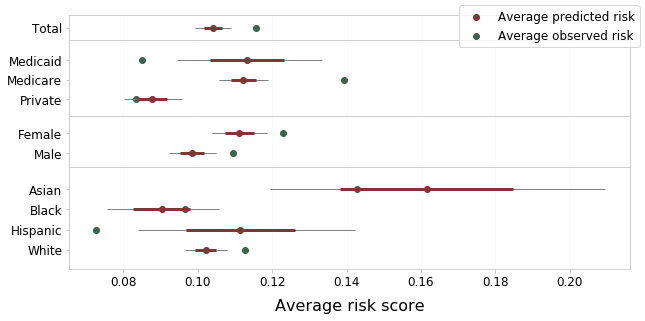

In [12]:
reload(cb)
output_json = json_strat
cb.plot_calibration_mean_strat(output_json, 'mimic')

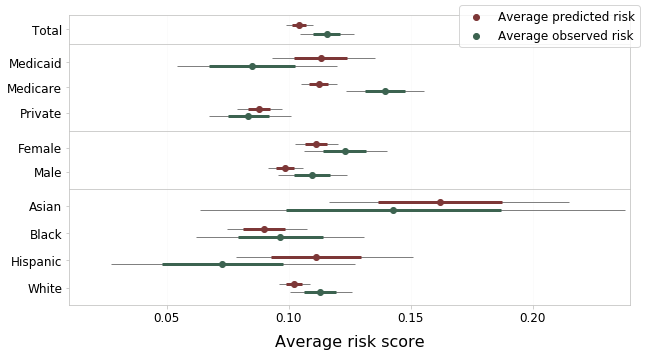

In [13]:
reload(cb)
output_json = json_nonstrat
cb.plot_calibration_mean(output_json, 'mimic')

> Overview:
- Slight underestimation of risk overall
- Insurance: 
    - Private: good calibration
    - Medicaid: overestimation of risk
    - Medicare: underestimation of risk (*confidence intervals are NOT overlapping*)
- Gender: same pattern as for total risk (slight underestimation)
- Ethnicity: 
    - White: very similar to overall behavior (underestimation)
    - Hispanic and Asian: similar overestimation of risk
    - Black: good calibration

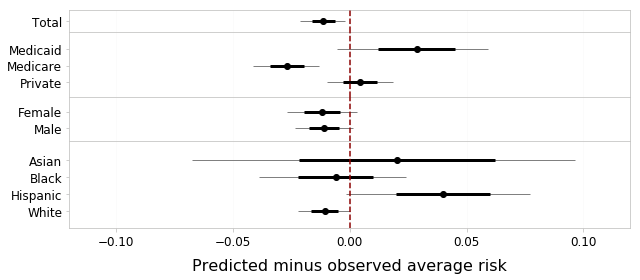

In [14]:
reload(cb)
cb.plot_calibration_diffs(output_json, 'mimic')

> Overview:
- overall: slight risk underestimation (linked to class imbalance?), statistically significant
- again, insurance is interesting: 
    - good overall calibration for private
    - Medicaid: risk overestimation
    - Medicare: severe risk underestimation, de-calibration is statistically significant as confidence interval does not include 0
- Gender: very similar
- Ethnicity:
    - White: similar to overall behavior
    - Hispanic: pronounced risk overestimation, confidence interval does almost not include 0
    - Black: Good calibration (matches with results from upper plot)
    - Asian: very large variation in how good calibration is, model is unstable

### B) Calibration plots

**Insurance**

In [15]:
results_priv = results[results["Insurance"] == 4].copy()
results_medicare = results[results["Insurance"] == 2].copy()
results_medicaid = results[results["Insurance"] == 3].copy()
results_pub = results[(results["Insurance"] == 1) | (results["Insurance"] == 2) | (results["Insurance"] == 3)].copy()

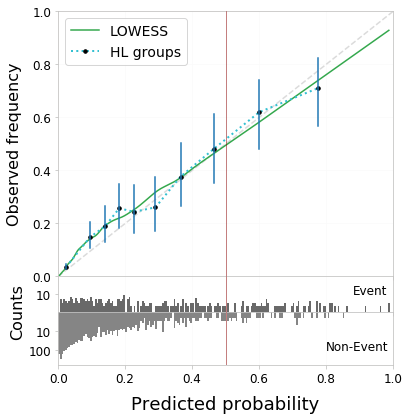

In [16]:
reload(cb)
cb.calibration_overall(results_pub, "pub_ins", data='mimic')

> almost perfect calibration, slight underestimation for low risk patients

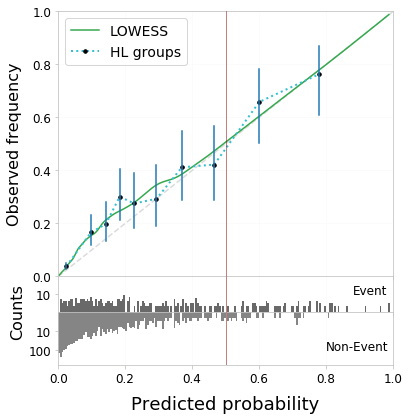

In [17]:
cb.calibration_overall(results_medicare, "pub_medicare", data='mimic')

> similar pattern as for complete public insurance cohort, but underestimation for low risk patients more pronounced 

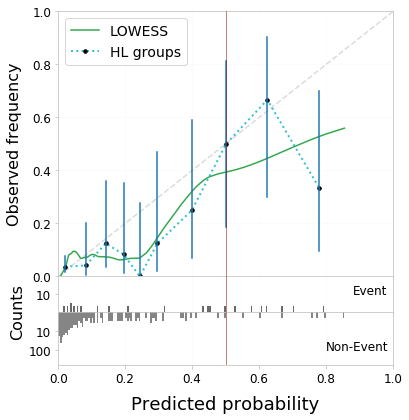

In [18]:
cb.calibration_overall(results_medicaid, "pub_medicaid", data='mimic')

> risk overestimation for medium and high risk patients; bad overall calibration but model output also visibly suffers from little test data

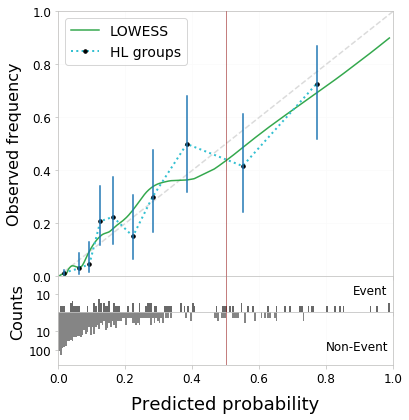

In [19]:
cb.calibration_overall(results_priv, "priv_ins", data='mimic')

> overall calibration satisfactory, though overestimation in risk for high-risk patients

**Gender**

In [20]:
results_F = results[results["Gender"] == 1].copy()
results_M = results[results["Gender"] == 2].copy()

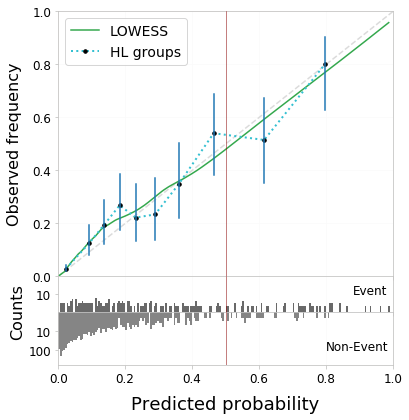

In [21]:
cb.calibration_overall(results_F, "gen_F", data='mimic')

> almost perfect calibration; very similar pattern as for overall model calibration

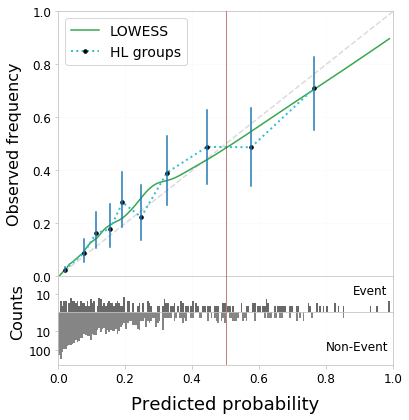

In [22]:
reload(cb)
cb.calibration_overall(results_M, "gen_M", data='mimic')

> slightly less well calibrated than for females, however still reasonably good

**Ethnicity**

In [23]:
results_asian = results[results["Ethnicity"] == 1].copy()
results_black = results[results["Ethnicity"] == 2].copy()
results_white = results[results["Ethnicity"] == 4].copy()
results_hispa = results[results["Ethnicity"] == 3].copy()

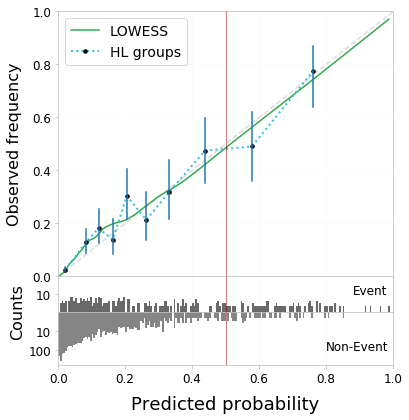

In [24]:
cb.calibration_overall(results_white, "eth_white", data='mimic')

> extremely similar to overall model (make up 70% of total test data population)

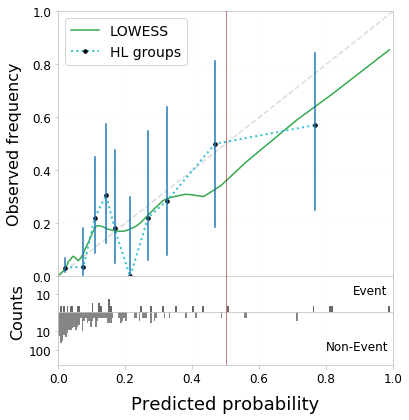

In [25]:
cb.calibration_overall(results_black, "eth_black", data='mimic')

> risk underestimation for low risk patients but an overestimation for higher risk patients

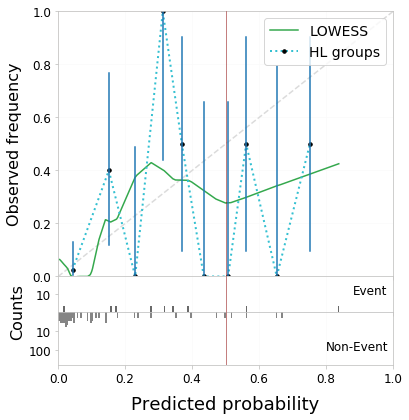

In [26]:
cb.calibration_overall(results_asian, "eth_asian", data='mimic')

> small test data results in very unstable behavior of calibration curves; overestimation, followed by underestimation and a second round of overestimation

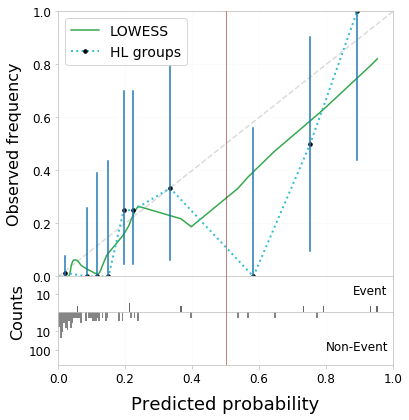

In [27]:
cb.calibration_overall(results_hispa, "eth_hispa", data='mimic')

> noisy due to small test set but risk is generally underestimated